In [2]:
from collections import defaultdict
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import imblearn
import sklearn.metrics as metrics
import xgboost

from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, LassoCV, Lasso
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel, chi2, RFE, RFECV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, plot_confusion_matrix, f1_score, recall_score
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.metrics import fbeta_score

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
#Setting up graph standards
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Table of Contents

* [Data Loading](#data_load)
* [Baseline Evaluation: Logistic Regression](#base)
* [Modeling](#mod)
    * [Logistic Regression](#log)
    * [Random Forest](#rf)
    * [Gradient Boosting](#gbm)
* [Fine Tuning](#fine)
* [Decision Threshold](#desc)
* [Classification Report and Confusion Matrix](#class)

## Creating Different Feature Sets <a class="anchor" id="data_load"></a>

#### Original Dataset

In [4]:
X = pd.DataFrame(load_breast_cancer().data)
X.columns = load_breast_cancer().feature_names
y = pd.DataFrame(load_breast_cancer().target)

In [5]:
y = y.replace({0:True, 1:False})

In [6]:
y.value_counts()

False    357
True     212
dtype: int64

In [7]:
#Splitting test/train 50/50
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 42)
print(f"Train Data: {X_train.shape}, {y_train.shape}")
print(f"Test Data: {X_test.shape}, {y_test.shape}")

Train Data: (284, 30), (284, 1)
Test Data: (285, 30), (285, 1)


In [8]:
#Upsampling training data
counter = Counter(y_train)
upsample = SMOTE()
X_train, y_train = upsample.fit_resample(X_train, y_train)

print(f"Total Data after Upsampling: {len(X_train)}")
print(f"Train Data: {X_train.shape}, {y_train.shape}")
print(f"Test Data: {X_test.shape}, {y_test.shape}")

#Scaling train and test data
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(f"Scaled Train Data: {X_train.shape}, {y_train.shape}")
print(f"Scaled Test Data: {X_test.shape}, {y_test.shape}")

Total Data after Upsampling: 340
Train Data: (340, 30), (340, 1)
Test Data: (285, 30), (285, 1)
Scaled Train Data: (340, 30), (340, 1)
Scaled Test Data: (285, 30), (285, 1)


#### SelectKBest Feature Set<a class="anchor" id="selectkbest"></a>

In [9]:
%store -r feature_set_skb

In [10]:
%store -r X_test_skb
print(f"Baseline Test Data: {X_test.shape}")
print(f"SelectKBest Test Data: {X_test_skb.shape}")

Baseline Test Data: (285, 30)
SelectKBest Test Data: (285, 15)


#### Feature ranking with recursive feature elimination and cross-validated selection Feature Set <a class="anchor" id="rfecv"></a>

In [11]:
%store -r rfecv_clf_feature_set

In [12]:
%store -r X_test_rfecv
print(f"Baseline Test Data: {X_test.shape}")
print(f"RFECV Test Data: {X_test_rfecv.shape}")

Baseline Test Data: (285, 30)
RFECV Test Data: (285, 16)


#### Lasso Feature Set <a class="anchor" id="Lasso"></a>

In [13]:
%store -r sfm_feature_set

In [14]:
%store -r X_test_lasso
print(f"Baseline Test Data: {X_test.shape}")
print(f"Lasso Test Data: {X_test_lasso.shape}")

Baseline Test Data: (285, 30)
Lasso Test Data: (285, 22)


#### Random Forest Feature Importance Feature Set <a class="anchor" id="rffi"></a>

In [15]:
corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)

In [16]:
cluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X_train_rfi = X_train[:, selected_features]
X_test_rfi = X_test[:, selected_features]
#%store -r X_train_rfi
#%store -r X_test_rfi

print(f"Baseline Test Data: {X_test.shape}")
print(f"RFI Test Data: {X_test_rfi.shape}")

Baseline Test Data: (285, 30)
RFI Test Data: (285, 14)


#### Mean Feature Set

In [20]:
%store -r X_train_mean
%store -r X_test_mean
X_test_mean.shape

(285, 10)

#### Less Correlated Feature Set

In [24]:
%store -r X_train_clean
%store -r X_test_clean
X_test_clean.shape

(285, 16)

### Baseline Logistic Regression Model <a class="anchor" id="base"></a>

##### Original Feature Set

In [25]:
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)
base_dict = {}

# Accuray On Test Data
probs = clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print(f"ROC AUC:{roc_auc*100}%")
base_dict.update({"Original":roc_auc*100})

y_score =clf.predict_proba(X_test)[:, 1]
orig_score = metrics.roc_auc_score(y_test, y_score)


ROC AUC:99.73262032085562%


0.9973262032085561

#### Select K Best Feature set

In [26]:
clf = LogisticRegression(random_state=42)
clf.fit(feature_set_skb, y_train)

# Accuray On Test Data
probs = clf.predict_proba(X_test_skb)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print(f"ROC AUC:{roc_auc*100}%")
#fs_dict.update({"SKB_LogReg":[f"ROC AUC: {roc_auc*100}%",f"Accuracy:{clf.score(X_test_skb, y_test)}"]})
base_dict.update({"Select K Best":roc_auc*100})

y_score =clf.predict_proba(X_test_skb)[:, 1]
skb_score = metrics.roc_auc_score(y_test, y_score)


ROC AUC:99.1542071374004%


0.9915420713740041

#### RFECV Feature Set

In [27]:
clf = LogisticRegression(random_state=42)
clf.fit(rfecv_clf_feature_set, y_train)

# Accuray On Test Data
probs = clf.predict_proba(X_test_rfecv)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print(f"ROC AUC:{roc_auc*100}%")
base_dict.update({"RFECV":roc_auc*100})

y_score =clf.predict_proba(X_test_rfecv)[:, 1]
rfecv_score = metrics.roc_auc_score(y_test, y_score)




ROC AUC:99.77081741787623%


0.9977081741787623

#### Lasso Feature Set

In [28]:
clf = LogisticRegression(random_state=42)
clf.fit(sfm_feature_set, y_train)

# Accuray On Test Data
probs = clf.predict_proba(X_test_lasso)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print(f"ROC AUC:{roc_auc*100}%")
base_dict.update({"Lasso CV":roc_auc*100})

y_score =clf.predict_proba(X_test_lasso)[:, 1]
lasso_score = metrics.roc_auc_score(y_test, y_score)


ROC AUC:99.72170686456401%


#### Random Forest Feature Importance Feature Set

In [29]:
clf = LogisticRegression(random_state=42)
clf.fit(X_train_rfi, y_train)

# Accuray On Test Data
probs = clf.predict_proba(X_test_rfi)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print(f"ROC AUC:{roc_auc*100}%")
#fs_dict.update({"RF_Feat_Importance_LogReg":[f"ROC AUC: {roc_auc*100}%",f"Accuracy:{clf.score(X_test_rfi, y_test)}"]})
base_dict.update({"RFFI":roc_auc*100})

y_score =clf.predict_proba(X_test_rfi)[:, 1]
rfi_score = metrics.roc_auc_score(y_test, y_score)

print(rfi_score)


ROC AUC:99.74899050529304%
0.9974899050529303


#### Mean Feature Set

In [30]:
clf = LogisticRegression(random_state=42)
clf.fit(X_train_mean, y_train)

# Accuray On Test Data
probs = clf.predict_proba(X_test_mean)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print(f"ROC AUC:{roc_auc*100}%")
base_dict.update({"Mean Features":roc_auc*100})

y_score =clf.predict_proba(X_test_mean)[:, 1]
mean_score = metrics.roc_auc_score(y_test, y_score)

ROC AUC:99.02870239004692%


0.9902870239004692

#### Less correlated Feature Set

In [31]:
clf = LogisticRegression(random_state=42)
clf.fit(X_train_clean, y_train)

# Accuray On Test Data
probs = clf.predict_proba(X_test_clean)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print(f"ROC AUC:{roc_auc*100}%")
base_dict.update({"Less Correlated":roc_auc*100})

y_score =clf.predict_proba(X_test_clean)[:, 1]
clean_score = metrics.roc_auc_score(y_test, y_score)


ROC AUC:99.0014187493179%


0.990014187493179

In [32]:
baseline_data = pd.DataFrame.from_dict(base_dict, orient='index')
baseline_data.sort_values(by=0, ascending=False)

,0
RFECV,99.770817
RFFI,99.748991
Original,99.732620
Lasso CV,99.721707
Select K Best,99.154207
Mean Features,99.028702
Less Correlated,99.001419


The Random Forest Feature Importance is the best data set. 

### Modeling <a class="anchor" id="mod"></a>

#### Log Reg Grid Search with RFECV Feature Set <a class="anchor" id="log"></a>

In [33]:
parameters = {
    'penalty': ['l1', 'l2', 'none'],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': np.arange(100, 200, 10),
    'C':np.arange(0, 1.5, 0.2)}
grid_cv = GridSearchCV(estimator = LogisticRegression(random_state = 42), param_grid = parameters, cv = 5)
grid_cv.fit(rfecv_clf_feature_set, y_train)
print(grid_cv.best_score_)
print(grid_cv.best_params_)

0.9823529411764707
{'C': 0.4, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}


In [34]:
print(classification_report(y_test, grid_cv.best_estimator_.predict(X_test_rfecv)))
grid_cv.best_estimator_.score(X_test_rfecv, y_test)

              precision    recall  f1-score   support

       False       0.99      0.98      0.98       187
        True       0.96      0.98      0.97        98

    accuracy                           0.98       285
   macro avg       0.97      0.98      0.98       285
weighted avg       0.98      0.98      0.98       285



0.9789473684210527

In [35]:
# Setting the model to the best combination of parameters
mod = grid_cv.best_estimator_

# Train the model using the training sets 
mod.fit(rfecv_clf_feature_set, y_train)

LogisticRegression(C=0.4, random_state=42, solver='liblinear')

In [36]:
y_score_log =grid_cv.best_estimator_.predict_proba(X_test_rfecv)[:,1]
metrics.roc_auc_score(y_test, y_score_log)

0.9978718760231365

### Random Forest Model <a class="anchor" id="rf"></a>

In [37]:
## RF Feature importanct 
rf = RandomForestClassifier(random_state=42)
rf.fit(rfecv_clf_feature_set, y_train)

probs = rf.predict_proba(X_test_rfecv)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print('RF Feature Importance Feature Set')
print({roc_auc*100})

RF Feature Importance Feature Set
{99.77081741787624}


In [38]:
parameters_rf = {'n_estimators': [4, 6, 9, 10, 15], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1, 5, 8]
             }
grid_cv_rf = GridSearchCV(estimator = RandomForestClassifier(random_state = 42), param_grid = parameters_rf, cv = 5)
grid_cv_rf.fit(rfecv_clf_feature_set, y_train)
print(grid_cv_rf.best_score_)
print(grid_cv_rf.best_params_)

0.9705882352941175
{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 15}


In [39]:
print(classification_report(y_test, grid_cv.best_estimator_.predict(X_test_rfecv)))
grid_cv_rf.best_estimator_.score(X_test_rfecv, y_test)

              precision    recall  f1-score   support

       False       0.99      0.98      0.98       187
        True       0.96      0.98      0.97        98

    accuracy                           0.98       285
   macro avg       0.97      0.98      0.98       285
weighted avg       0.98      0.98      0.98       285



0.9543859649122807

In [40]:
y_score_rf =grid_cv_rf.best_estimator_.predict_proba(X_test_rfecv)[:,1]
metrics.roc_auc_score(y_test, y_score_rf)

0.9945978391356542

### Gradient Boosting Model  <a class="anchor" id="gbm"></a>

In [41]:
## RF Feature importanct 
gbm = GradientBoostingClassifier(random_state=42) 
gbm.fit(rfecv_clf_feature_set, y_train)

probs = gbm.predict_proba(X_test_rfecv)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print('RF Feature Importance Feature Set')
print(f"ROC AUC:{roc_auc*100}%")

RF Feature Importance Feature Set
ROC AUC:99.31790898177452%


In [42]:
n_estimators = np.arange(100,600,100)
max_depth = [1,2,4,8]
learning_rate = [.05,.1,.2,.5,1]

param_dist = {'n_estimators': n_estimators, 'max_depth':max_depth, 'learning_rate':learning_rate}

grid_cv_gbm = GridSearchCV(estimator =GradientBoostingClassifier(random_state=42) , param_grid = param_dist, cv = 5)
grid_cv_gbm.fit(rfecv_clf_feature_set, y_train)
print(grid_cv_gbm.best_score_)
print(grid_cv_gbm.best_params_)

0.9764705882352942
{'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 500}


In [43]:
print(classification_report(y_test, grid_cv_gbm.best_estimator_.predict(X_test_rfecv)))
grid_cv_gbm.best_estimator_.score(X_test_rfecv, y_test)


              precision    recall  f1-score   support

       False       0.99      0.98      0.98       187
        True       0.96      0.98      0.97        98

    accuracy                           0.98       285
   macro avg       0.97      0.98      0.98       285
weighted avg       0.98      0.98      0.98       285



0.9789473684210527

In [44]:
y_score =grid_cv_gbm.best_estimator_.predict_proba(X_test_rfecv)[:,1]


In [45]:
metrics.roc_auc_score(y_test, y_score)

0.9973262032085561

#### Testing selected data set 

In [46]:
model_params = {
    'random_forest': {'model': RandomForestClassifier(random_state=42),
                      'params' : {
              'n_estimators': [4, 6, 9, 10, 15], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1, 5, 8]}},
    'logistic_regression' : {'model': LogisticRegression(random_state=42),
                            'params': {
                                'penalty': ['l1', 'l2', 'none'],
                                'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                                'max_iter': np.arange(100, 200, 10),
                                'C':np.arange(0, 1.5, 0.2)}},
    'gradient_boosting' : {'model': GradientBoostingClassifier(random_state=42),
                       'params': {
                           'n_estimators': np.arange(100,600,100), 
                           'max_depth':[1,2,4,8], 
                           'learning_rate':[.05,.1,.2,.5,1]}}
}


In [47]:
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(rfecv_clf_feature_set, y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df_model = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df_model.to_csv('models.csv')


In [48]:
df_model

,model,best_score,best_params
0,random_forest,0.970588,"{'criterion': 'entropy', 'max_depth': 5, 'max_..."
1,logistic_regression,0.982353,"{'C': 0.4, 'max_iter': 100, 'penalty': 'l2', '..."
2,gradient_boosting,0.976471,"{'learning_rate': 0.5, 'max_depth': 2, 'n_esti..."


In [49]:
print(classification_report(y_test, clf.best_estimator_.predict(X_test_rfecv)))


              precision    recall  f1-score   support

       False       0.99      0.98      0.98       187
        True       0.96      0.98      0.97        98

    accuracy                           0.98       285
   macro avg       0.97      0.98      0.98       285
weighted avg       0.98      0.98      0.98       285



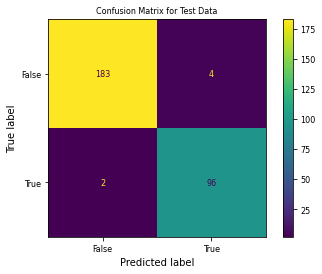

In [50]:

plot_confusion_matrix(clf,X_test_rfecv, y_test)
plt.title("Confusion Matrix for Test Data")
plt.savefig('matrix_final.png')
plt.show()

## Fine Tuning  <a class="anchor" id="fine"></a>

In [51]:
df_model.sort_values(by='best_score', ascending=False)

,model,best_score,best_params
1,logistic_regression,0.982353,"{'C': 0.4, 'max_iter': 100, 'penalty': 'l2', '..."
2,gradient_boosting,0.976471,"{'learning_rate': 0.5, 'max_depth': 2, 'n_esti..."
0,random_forest,0.970588,"{'criterion': 'entropy', 'max_depth': 5, 'max_..."


In [52]:
clf = LogisticRegression(random_state=42, C=0.4, max_iter=100, penalty='l2', solver='liblinear')
clf.fit(rfecv_clf_feature_set, y_train)

LogisticRegression(C=0.4, random_state=42, solver='liblinear')

In [53]:
probs = clf.predict_proba(X_test_rfecv)
preds = probs[:,1]


precision, recall, thresholds = precision_recall_curve(y_test, preds)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)


y_score =clf.predict_proba(X_test_rfecv)[:, 1]
roc_auc = metrics.roc_auc_score(y_test, y_score)

pr_auc = metrics.auc(recall, precision)


In [54]:
roc_auc

0.9978718760231365

In [55]:
pr_auc

0.9964003205450987

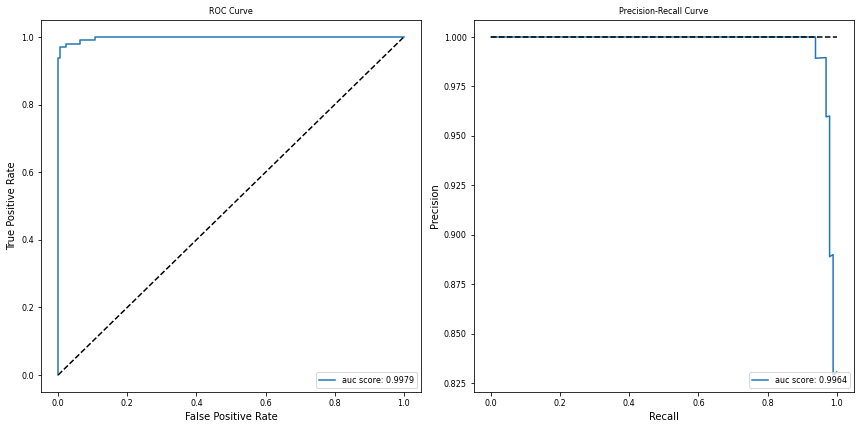

In [56]:
h_line = len(y_test[y_test==1]) / len(y_test) # no skill line in precision/recall curve

_ = plt.subplots(figsize=(12,6))
f1 = plt.subplot(1,2,1)
_ = plt.plot(fpr, tpr)
_ = plt.plot([0,1],[0,1], 'k--')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.legend([f'auc score: {round(roc_auc, 4)}'], loc='lower right')

f2 = plt.subplot(1,2,2)
_ = plt.plot(recall, precision)
_ = plt.plot([0, 1], [h_line, h_line], linestyle='--', color='k')
_ = plt.xlabel('Recall')
_ = plt.ylabel('Precision')
_ = plt.title('Precision-Recall Curve')
_ = plt.legend([f'auc score: {round(pr_auc, 4)}'], loc='lower right')
plt.savefig('ROC_PR_RFECV.png') 
plt.tight_layout()

### Decision Threshold <a class="anchor" id="fine"></a>

In [57]:
pred_df = pd.DataFrame({'precision':precision[:-1], 'recall':recall[:-1], 'threshold':thresholds})

In [58]:
pred_df.head()

,precision,recall,threshold
0,0.830508,1.000000,0.196100
1,0.829060,0.989796,0.205668
2,0.836207,0.989796,0.214414
3,0.843478,0.989796,0.218683
4,0.850877,0.989796,0.238010


In [66]:
pred_df[pred_df.precision == 1].sort_values(by='recall', ascending=False).head(1)

,precision,recall,threshold,fb_2,fb_3
26,1.0,0.938776,0.780813,0.950413,0.944559


In [67]:
#pred_df.to_csv("pre_df_RFECV_1.csv")

In [114]:
thresholds = sorted(list(set(preds)))
                  
precision_list = []

recall_list = []

In [115]:
for thresh in thresholds:
    y_pred_temp = preds > thresh
    precision_list.append(precision_score(y_test, y_pred_temp))
    recall_list.append(recall_score(y_test, y_pred_temp))

In [119]:
precision_list = sorted(precision_list)

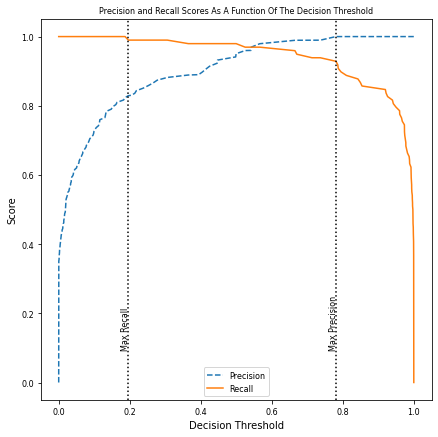

In [121]:
_ = plt.figure(figsize=(7, 7))
_ = plt.title('Precision and Recall Scores As A Function Of The Decision Threshold')
_ = plt.plot(thresholds, precision_list, '--', label='Precision')
_ = plt.plot(thresholds, recall_list, '-', label='Recall')
_ = plt.axvline(x=0.780813, c='k', ls=':')
_ = plt.annotate('Max Precision', xy=(0.760,0.1), rotation=90)
_ = plt.axvline(x=0.1961, c='k', ls=':')
_ = plt.annotate('Max Recall', xy=(0.175,0.1), rotation=90)
_ = plt.ylabel('Score')
_ = plt.xlabel('Decision Threshold')
_ = plt.savefig('Decision_RFECV_new2.png') 
_ = plt.legend(loc='best')

### Classification Report and Confusion Matrix <a class="anchor" id="class"></a>

In [69]:
# Adjust the decision thresholds  
max_recall = np.where(preds >= 0.1961, 1, 0)
max_pred = np.where(preds >= 0.780813, 1, 0)

In [71]:
print('Classification Report - Max Recall')
print(classification_report(y_test, max_recall))

Classification Report - Max Recall
              precision    recall  f1-score   support

       False       1.00      0.89      0.94       187
        True       0.83      1.00      0.91        98

    accuracy                           0.93       285
   macro avg       0.92      0.95      0.93       285
weighted avg       0.94      0.93      0.93       285



In [72]:
confusion_matrix(y_test, max_recall)

array([[167,  20],
       [  0,  98]])

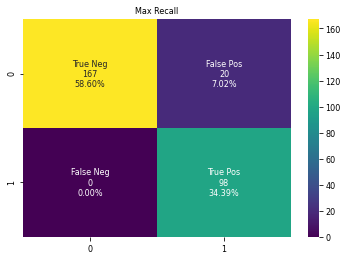

In [73]:
cmatrix_maxr = confusion_matrix(y_test, max_recall)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cmatrix_maxr.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cmatrix_maxr.flatten()/np.sum(cmatrix_maxr)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
_ = sns.heatmap(cmatrix_maxr, annot=labels,cmap='viridis', fmt='')
_ = plt.savefig('CMatrix_RFECV.png') 
_ = plt.title('Max Recall')

In [74]:
print('Classification Report - Max Precision')
print(classification_report(y_test, max_pred))

Classification Report - Max Precision
              precision    recall  f1-score   support

       False       0.97      1.00      0.98       187
        True       1.00      0.94      0.97        98

    accuracy                           0.98       285
   macro avg       0.98      0.97      0.98       285
weighted avg       0.98      0.98      0.98       285

